
## Régression logistique

_Fichier à modifier_ : [`logistic_regression.ipynb`](./logistic_regression.ipynb)

La régression logistique fonctionne un peu comme la régression linéaire, cependant c'est un problème de classification (ici binaire).

## Implémentation

1. Créer les données :
   1. Générer un jeu de données `S` de couples $(x, y)$ où $x \in \mathbb{R}^2$ et $y = \mathbf{1}_{w x + b > 0}$. Garder les paramètres $\theta := (w, b)$ pour la suite.
   2. Visualiser les données et la frontière $w x + b = 0$.
   3. Séparer les données en deux datasets : un jeu d'entraînement (`S_train`, 80 %) et un jeu de validation (`S_test`, 20 %).
2. Entraîner un modèle $\theta_0$ de régression logistique (`nn.Linear` + `nn.Sigmoid`) avec la perte _binary cross-entropy_ (`torch.nn.BCELoss`) et la descente de gradient stochastique (`torch.optim.SGD`).
3. Créer un nouveau jeu de données corrompu `S_corr` à partir `S` en appliquant du _label flipping_ à une fraction $\alpha \in [0, 1]$ des données $(x, y)$ : pour cette partie, on remplace le label $y$ par son opposé, $1 - y$.
4. Visualiser les données corrompues.
5. Créer un nouveau modèle  $\theta_1$ et l'entraîner sur ce nouveau jeu de données corrompu. Afficher la précision de $\theta_1$ sur `S_test`.
6. Dans les sous-questions suivantes, on va créer de **nouveaux** modèles avec des paramètres différents (écrire une fonction pour éviter de répéter le code de la question précédente). Afficher les différentes courbes de précision lorsque l'on fait varier un paramètre.
   1. Faire varier la valeur de $\alpha$.
   2. Créer un nouveau jeu de données de sorte que les valeurs de $x$ ne sont pas réparties uniformément, et refaire l'expérience. Par exemple, on concentre les valeurs de $x$ autour de $1$ ou plusieurs clusters (avec un mélange gaussien par exemple). Faire en sorte qu'au moins un des clusters soit proche de la frontière de classification. Que se passe-t-il ? On utilisera ce nouveau jeu de données dans la suite.
   3. Que se passe-t-il si l'on applique le _label flipping_ spécifiquement sur les points $x$ très proches de la frontière ?
   4. Faire varier la dimension de `x`.
7. _Bonus_ : que se passe-t-il si l'on rajoute des couches (_hidden layers_) ?
8. _Bonus_ : que se passe-t-il avec peu de données ?
9.  _Bonus_ : que se passe-t-il si au lieu de créer un nouveau modèle $\theta_1$, on continue l'entraînement du modèle $\theta$ sur `S_corr` ?

## Analyse
   1. Faire le lien avec les chapitres sur la classification dans le cours de Statistiques.
   2. Expliquer brièvement le concept du mélange gaussien.
   3. Établir une relation empirique entre l'imprécision du modèle et la proportion de points "proches" de la frontière.
   4. Faire le lien avec le concept du jailbreaking. Pour illustration, voir la slide 26 : _Évasion (jailbreaking)_ de la [conférence de Lê Nguyên Hoang en décembre 2024](https://science4all.org/wp-content/uploads/2024/12/piaf.pdf)
   5. Établir une relation empirique entre l'imprécision du modèle et la dimension de `x`.
   6. Peut-on imaginer un moyen d'identifier l'empoisonnement, de filtrer les données suspicieuses ou d'agréger les gradients d'un mini-batch de manière robuste ? Exemple d'approche sur [Scikit-Learn](https://scikit-learn-extra.readthedocs.io/en/stable/modules/robust.html)

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import numpy as np


### Résultats déterministes

In [93]:
import random
seed = 0x2023_2024
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)
random.seed(seed)

## Générer des données aléatoires

In [94]:
X = torch.randn((1000, 2))
X1 = X[:, 0]
X2 = X[:, 1]
W = torch.randn(1)

b = torch.randn(1)

Z = W * X1 + b
y = (X2 > Z).int().float()

S = TensorDataset(X,y)

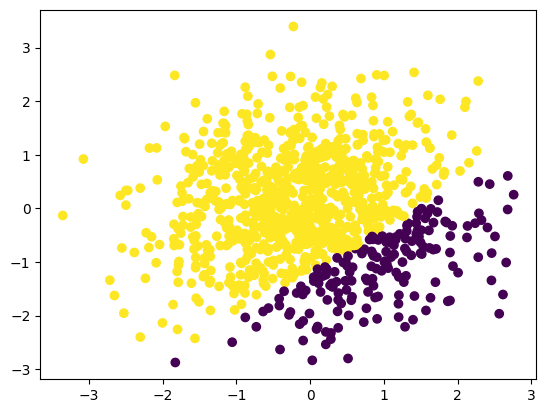

In [95]:
plt.scatter(X1, X2, c=y)

### Séparation du jeu de données (entraînement / validation)

In [96]:
N = len(S)

In [97]:
batch_size = 16

def train_test_split(S):
    S_train, S_test = random_split(S, [0.8, 0.2])
    train_loader = DataLoader(S_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(S_test, batch_size=batch_size)
    return train_loader, val_loader

### Définition du Modèle

In [98]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Couche linéaire

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoïde pour la probabilité
    
model = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

In [99]:
def make_optimizer(model):
    # Descente de gradient
    return optim.SGD(model.parameters(), lr=0.01)

In [100]:
# 3. Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# ATTENTION : il faut absolument recréer l'optimizer
# à chaque fois qu'on ré-entraîne un nouveau modèle
optimizer = make_optimizer(model)

### Entraînement

In [101]:
def train_model(model, train_loader, val_loader, verbose=False):
    # ATTENTION : l'optimiseur doit toujours être recréé
    optimizer = make_optimizer(model)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()  # Mode entraînement
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
        
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()  # Mode évaluation
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()
        
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}")


Epoch 10/100, Loss: 0.3392, Val Loss: 0.3477
Epoch 20/100, Loss: 0.3147, Val Loss: 0.2581
Epoch 30/100, Loss: 0.1654, Val Loss: 0.2164
Epoch 40/100, Loss: 0.1974, Val Loss: 0.1912
Epoch 50/100, Loss: 0.1100, Val Loss: 0.1738
Epoch 60/100, Loss: 0.2345, Val Loss: 0.1609
Epoch 70/100, Loss: 0.2203, Val Loss: 0.1509
Epoch 80/100, Loss: 0.1317, Val Loss: 0.1427
Epoch 90/100, Loss: 0.1462, Val Loss: 0.1359
Epoch 100/100, Loss: 0.0952, Val Loss: 0.1301


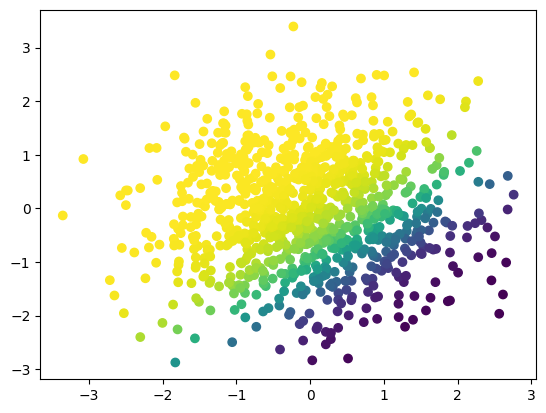

In [102]:
train_loader, val_loader = train_test_split(S)
train_model(model, train_loader, val_loader, verbose=True)

model.eval()
# S.tensors[0] ?

# TODO: tracer la frontière de prédiction et la frontière réelle
plt.scatter(X1,X2,c = model(S[:][0]).detach().clone())

### Jeu de données Corrompu

In [103]:
def make_corrupted_dataset(alpha):
    # Calculer combien de labels inverser
    num_labels_to_flip = int(alpha * N)

    # Sélectionner aléatoirement les indices à inverser
    flip_indices = np.random.choice(N, num_labels_to_flip, replace=False)

    Y_corr = y.clone()
    Y_corr[flip_indices] = 1 - Y_corr[flip_indices]

    return TensorDataset(X, Y_corr)

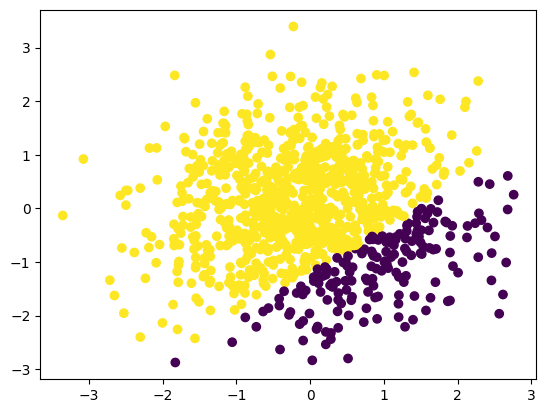

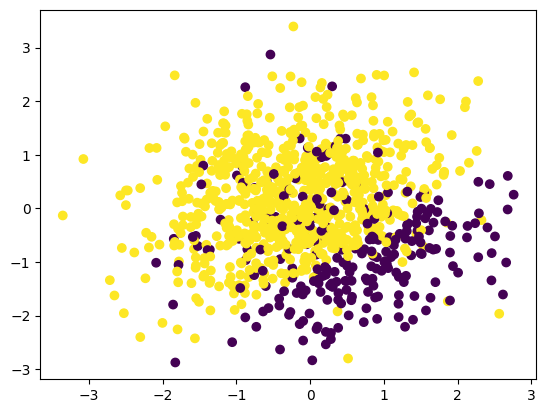

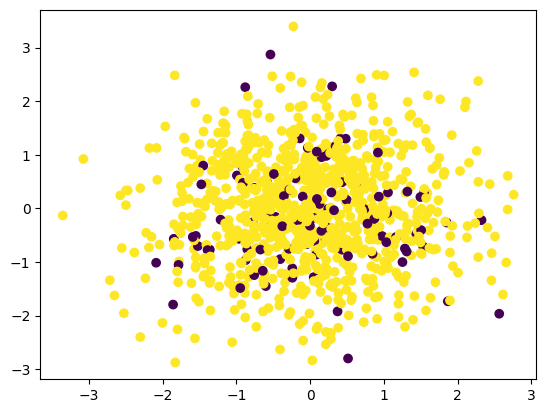

In [104]:
S_corr = make_corrupted_dataset(alpha=0.1)
Y_corr = S_corr.tensors[1]

plt.figure(1)
plt.scatter(X1, X2, c=y)
plt.figure(2)
plt.scatter(X1, X2, c=Y_corr)
plt.figure(3)
plt.scatter(X1,X2, c=(y==Y_corr))

### Entraînement sur les données corrompues

In [105]:
train_loader_corrupted, _ = train_test_split(S_corr)

model1 = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

# On évalue le modèle corrompu sur les données NON corrompues
train_model(model1, train_loader_corrupted, val_loader, verbose=True)

Epoch 10/100, Loss: 0.4366, Val Loss: 0.4552
Epoch 20/100, Loss: 0.5240, Val Loss: 0.3393
Epoch 30/100, Loss: 0.4290, Val Loss: 0.2947
Epoch 40/100, Loss: 0.3654, Val Loss: 0.2714
Epoch 50/100, Loss: 0.3857, Val Loss: 0.2573
Epoch 60/100, Loss: 0.7157, Val Loss: 0.2481
Epoch 70/100, Loss: 0.5424, Val Loss: 0.2417
Epoch 80/100, Loss: 0.4869, Val Loss: 0.2372
Epoch 90/100, Loss: 0.2608, Val Loss: 0.2339
Epoch 100/100, Loss: 0.2961, Val Loss: 0.2315


##### Fonction de précision

In [106]:
def accuracy(model, dataloader):
    model.eval()  # Met le modèle en mode évaluation
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradient
        for inputs, labels in dataloader:
            outputs = model(inputs).squeeze()  # Prédictions du modèle
            # Appliquer un seuil de 0.5 pour la classification binaire
            predicted = (outputs > 0.5).float()  # Sortie 0 ou 1 selon le seuil
            total += len(labels)  # Nombre total d'exemples
            correct += (predicted == labels).sum().item()  # Nombre de prédictions correctes

    accuracy = correct / total  # Précision
    return accuracy

## Précision des différents modèles sur S_test

In [107]:
print(accuracy(model, val_loader))
print(accuracy(model1, val_loader))

0.99
0.98


# Variation de alpha

## Précision en fonction du pourcentage de corruption

In [182]:
acc = []

for alpha_ in np.linspace(0, 1, 60):
    # Nouveau jeu de données corrompu
    S_c = make_corrupted_dataset(alpha_)
    train_loader_corr, _ = train_test_split(S_c)
    # Création d'un nouveau modèle non entraîné
    model_a = LogisticRegressionModel(input_dim=2)
    # Entraînement du modèle
    train_model(model_a, train_loader_corr, val_loader)
    # Calcul de la précision
    acc.append(accuracy(model_a, val_loader))

plt.plot(np.linspace(0, 1, 60), acc)
plt.plot(np.linspace(0, 1, 60), -np.gradient(acc))


AssertionError: Size mismatch between tensors

# Jeu de données avec clusters

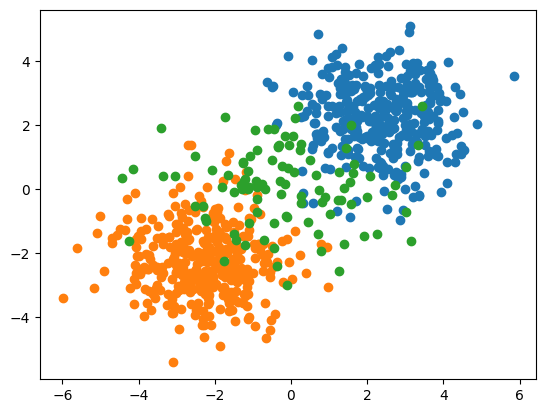

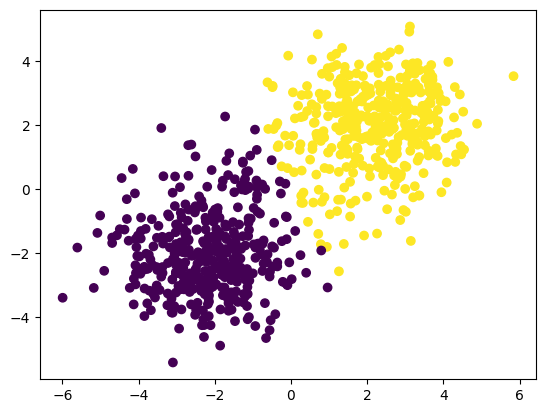

In [299]:
C1X = torch.normal(2.3,1.1,size=(350,2))
C1X1 = C1X[:, 0]
C1X2 = C1X[:, 1]

C2X = torch.normal(-2.3,1.1,size=(350,2))
C2X1 = C2X[:, 0]
C2X2 = C2X[:, 1]

RN = torch.normal(0,1.5,size=(100, 2))


plt.scatter(C1X1,C1X2)
plt.scatter(C2X1,C2X2)
plt.scatter(RN[:,0],RN[:,1])

SX = torch.cat((C1X1,C2X1,RN[:,0]))
SY = torch.cat((C1X2,C2X2,RN[:,1]))

Z = -2.3 * SX
yc = (SY > Z).int().float()

plt.figure()
plt.scatter(SX,SY,c=yc)

Sc = TensorDataset(torch.cat((C1X,C2X,RN)),yc)

## Corrompre au niveau de la frontière

In [300]:
## fonction de distance à la frontière

def dist(p,D):
    d = (D[0]*p[0]+D[1]*p[1]+D[2])/np.sqrt(D[0]**2 + D[1]**2)
    return abs(d)


## fonction des points voisins

def neigh_points (S,D,d):
    
    N = []
    for i in range (len(S[:][0])):
        if dist(S[i][0],D) < d:
            N.append(i)

    return torch.tensor(N)

def clone_tensor_dataset(dataset):
    cloned_tensors = tuple(tensor.clone() for tensor in dataset.tensors)
    return TensorDataset(*cloned_tensors)


## Corruption des données

def bord_corr (S,D,d,alpha):

    N = neigh_points(S,D,d)
    num_labels_to_flip = int(alpha * len(N))
    # Sélectionner aléatoirement les indices à inverser
    flip_indices = np.random.choice(len(N), num_labels_to_flip, replace=False)

    Y = S[:][1].clone()

    ##changement des indices
    for i in flip_indices:
        
        j = N[i]
        Y[j] = 1- Y[j]
    
    return TensorDataset(S[:][0].clone(),Y)
    


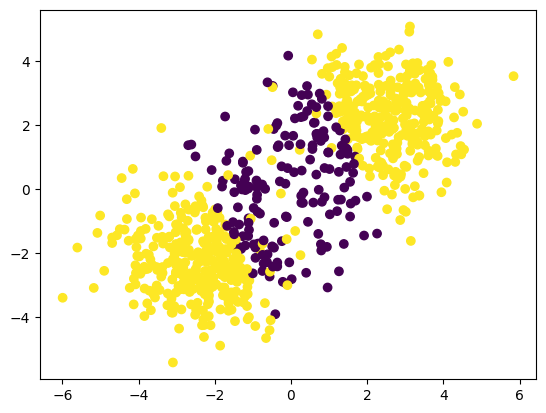

In [301]:
D=(2.3,1,0)
Sc_corr = bord_corr(Sc,D,2,0.9)
Sc_corr_X = Sc_corr[:][0]
Sc_corr_X1 = Sc_corr_X[:,0]
Sc_corr_X2 = Sc_corr_X[:,1]


plt.scatter(Sc_corr_X1,Sc_corr_X2,c = (Sc_corr[:][1]==Sc[:][1]))

In [302]:
model_cl = LogisticRegressionModel(input_dim=2)
model_cl_c = LogisticRegressionModel(input_dim=2)


train_loader, val_loader = train_test_split(Sc)
train_model(model_cl, train_loader, val_loader, verbose=True)
print(accuracy(model_cl,val_loader))



Epoch 10/100, Loss: 0.0535, Val Loss: 0.0883
Epoch 20/100, Loss: 0.0700, Val Loss: 0.0653
Epoch 30/100, Loss: 0.0323, Val Loss: 0.0562
Epoch 40/100, Loss: 0.0547, Val Loss: 0.0510
Epoch 50/100, Loss: 0.0311, Val Loss: 0.0474
Epoch 60/100, Loss: 0.0069, Val Loss: 0.0448
Epoch 70/100, Loss: 0.0115, Val Loss: 0.0427
Epoch 80/100, Loss: 0.0551, Val Loss: 0.0410
Epoch 90/100, Loss: 0.0307, Val Loss: 0.0395
Epoch 100/100, Loss: 0.0523, Val Loss: 0.0382
0.9875


In [303]:
train_loader_c, val_loader_c = train_test_split(Sc_corr)
train_model(model_cl_c,train_loader_c,val_loader_c,verbose=True)
print(accuracy(model_cl_c,val_loader_c))
print(accuracy(model_cl_c,val_loader))

Epoch 10/100, Loss: 0.3147, Val Loss: 0.3100
Epoch 20/100, Loss: 0.3475, Val Loss: 0.3067
Epoch 30/100, Loss: 0.2022, Val Loss: 0.3064
Epoch 40/100, Loss: 0.3689, Val Loss: 0.3066
Epoch 50/100, Loss: 0.4235, Val Loss: 0.3069
Epoch 60/100, Loss: 0.3032, Val Loss: 0.3072
Epoch 70/100, Loss: 0.5506, Val Loss: 0.3075
Epoch 80/100, Loss: 0.5626, Val Loss: 0.3076
Epoch 90/100, Loss: 0.1883, Val Loss: 0.3076
Epoch 100/100, Loss: 0.5052, Val Loss: 0.3077
0.81875
0.99375
